# Lab2 数据清洗

从各种渠道获得的源数据大多是“脏”数据，不符合人们的需求，如数据中含有唯一数据或重复数据、异常值数据（包含错误或存在偏离期望的异常值，如age=“-10”，明显是错误数据），以及数据不完整（如缺少属性值）等。而我们在使用数据的过程中对数据的要求是具有一致性、准确性、完整性、时效性、可信性、可解释性。

## 2.0 导入数据

In [1]:
import pandas as pd 
import numpy as np 
from pandas import Series,DataFrame
import matplotlib.pyplot as plt

raw = pd.read_csv("data/kobe.csv")
raw.head()


,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [2]:
#删除对最终结果无影响的id特征
drop_ids = ['game_event_id','game_id','team_id','shot_id']
for feature in drop_ids:
    raw = raw.drop(feature,axis = 1)

In [3]:
#创建一个新的特征time_remaining，用于替代minutes_remaining和seconds_remaining

raw['time_remaining'] = raw['minutes_remaining']*60 + raw['seconds_remaining']

In [4]:
#删除minutes_remaining和seconds_remaining特征

raw = raw.drop(['minutes_remaining','seconds_remaining'],axis = 1)

In [5]:
raw['season'].unique()

array(['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06',
       '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12',
       '2012-13', '2013-14', '2014-15', '2015-16', '1996-97', '1997-98',
       '1998-99', '1999-00'], dtype=object)

In [6]:
#将season数据处理为更简单易懂的格式
raw['season'] = raw['season'].apply(lambda x:int(x.split('-')[1]))
raw['season'].unique()
raw['season']=raw['season'].astype('object')

In [7]:
#lat,lon,loc_x,loc_y表达的是相同的含义，删除lat,lon特征
raw = raw.drop(['lat','lon'],axis = 1)

In [8]:
#action_type和combined_shot_type表达的含义相近，删除action_type
raw = raw.drop(['action_type'],axis = 1)

In [9]:
#shot_zone_area,shot_zone_basic,shot_zone_range表达的是相同的含义，保留一个
raw = raw.drop(['shot_zone_basic','shot_zone_range'],axis = 1)

In [10]:
#team_name和game_date对最终结果没有影响，删除这两个特征
raw = raw.drop(['team_name','game_date'],axis = 1)

In [11]:
#matchup和opponent表达的是相同的意思，保留opponent
raw = raw.drop('matchup',axis = 1)

In [12]:
#查看当前数据集的信息
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   combined_shot_type  30697 non-null  object 
 1   loc_x               30697 non-null  int64  
 2   loc_y               30697 non-null  int64  
 3   period              30697 non-null  int64  
 4   playoffs            30697 non-null  int64  
 5   season              30697 non-null  object 
 6   shot_distance       30697 non-null  int64  
 7   shot_made_flag      25697 non-null  float64
 8   shot_type           30697 non-null  object 
 9   shot_zone_area      30697 non-null  object 
 10  opponent            30697 non-null  object 
 11  time_remaining      30697 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 2.8+ MB


## 2.1 缺失值处理
缺失数据表示数据不完整，信息丢失，因而无法完成相关匹配和计算，如信息统计中年龄和性别丢失的情况。
缺失数据的处理主要有4种方式：
- 均值补差
- 利用同类均值补差
- 极大似然估计
- 多重补差

均值补差和利用同类均值补差是思维简单的处理方式，在实际中应用比较广泛。

极大似然估计是在概率上用最大可能的方式处理数据的缺失问题，其存在局部极值而且收敛速度过慢，计算较为复杂等问题。

多重补差是为每一个缺失值提供一个可能的替换值，以确保其无关性，构成替换阈，再根据其自由组合，从而对每一个替换结果进行总体预测，对结论进行总体评判。

多重补差这种思想来源于贝叶斯极大似然法，但比该方法在预判性上产生更多的多元化操作。



查看数据集存在缺失值的属性

In [13]:
raw = raw.replace(" ", np.nan)
print('Number of instances = %d' % (raw.shape[0]))
print('Number of attributes = %d' % (raw.shape[1]))
print('Number of missing values:')
print(raw.isnull().sum())

Number of instances = 30697
Number of attributes = 12
Number of missing values:
combined_shot_type       0
loc_x                    0
loc_y                    0
period                   0
playoffs                 0
season                   0
shot_distance            0
shot_made_flag        5000
shot_type                0
shot_zone_area           0
opponent                 0
time_remaining           0
dtype: int64


我们发现存在缺失值的属性是shot_made_flag，由于这个属性显示的是是否成功投篮的关键信息，我们不能进行简单的填补，因此这里我们选择丢弃该属性

In [14]:
print('Number of rows in original data = %d' % (raw.shape[0]))
raw = raw.dropna()
print('Number of rows after discarding missing values = %d' % (raw.shape[0]))

Number of rows in original data = 30697
Number of rows after discarding missing values = 25697


## 2.2 异常值识别和处理



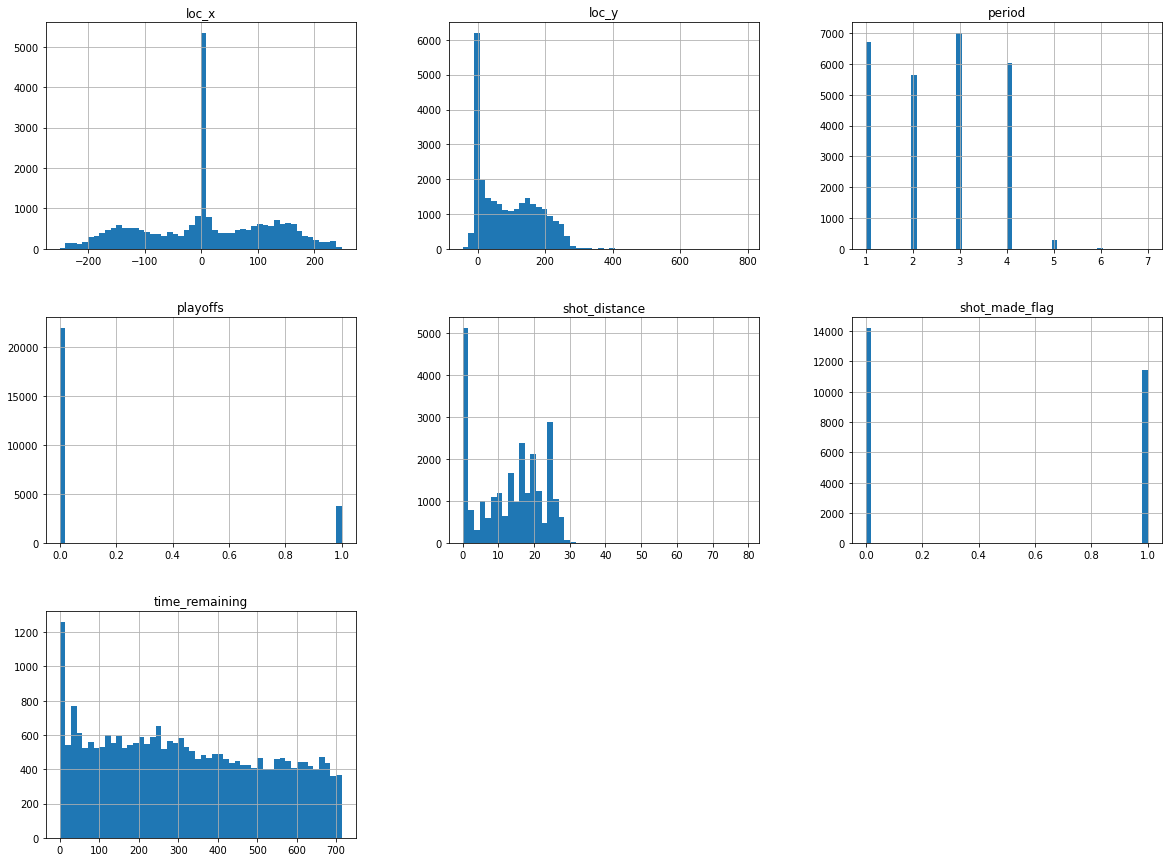

In [15]:
raw.hist(bins=50, figsize=(20,15))
plt.show()

<AxesSubplot:>

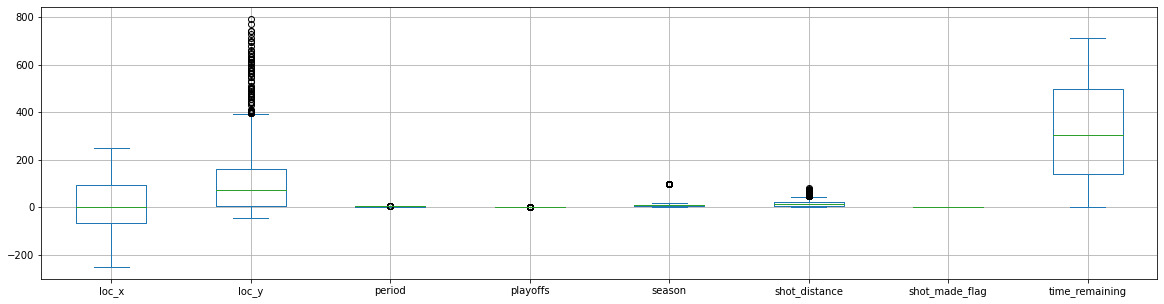

In [16]:
%matplotlib inline
#查看箱线图
data4 = raw.loc[:,['loc_x','loc_y','period','playoffs','season','shot_distance','shot_made_flag','time_remaining']]
data4.plot(kind='box',figsize=(20,5),grid=True)


为了丢弃异常值，我们可以计算每个属性的Z值，并删除那些包含异常高或低Z值属性的实例(例如，如果Z > 3或Z <= -3)

z-score 的计算定义如下：

$z =（x-μ）/σ$

这里的 x 为原始分值，z 为经过转换后的 z-score，μ 为总体样本空间的分值均值，σ 则为总体样本空间的标准差。

这里我们去除 Z > 3 或者 Z <= -3的属性值，行数由原来的25697减少为23612条。

In [17]:
# # 共有8个数值类属性
# print('Number of rows before discarding outliers = %d' % (raw.shape[0]))
# numerical_features = ['loc_x','loc_y','period','playoffs','season','shot_distance','shot_made_flag','time_remaining']
# data=raw.copy()
# for fea in numerical_features:
#     data_mean = data[fea].mean()
#     data_std = data[fea].std()
#     low = data_mean - 3 * data_std
#     up = data_mean + 3 * data_std
#     data[fea + '_outliers'] = data[fea].apply(lambda x: 0 if (x > low and x < up) else 1)  # 标记离群值
#     data = data[data[fea + '_outliers'] == 0]  # 过滤掉值为 1的行
#     data.drop([fea + '_outliers'], axis=1, inplace=True)  # 移除临时特征
# print('Number of attributes = %d' % (data.shape[1]))
# print('Number of rows after discarding outliers = %d' % (data.shape[0]))


## 2.3 数据去重
重复数据指多次出现的数据。若重复数据在整体样本中所占权重比其他数据大，容易导致结果的倾向性，因此对于重复数据常用的预处理方法是剔除，或者按比例降低其权重，进行数据的重新布局，形成概率分布。
- 对于一般数量可控的重复数据，通常采用的方法是简单的比较算法剔除。
- 对于重复的可控数据而言，一般通过代码实现对信息的匹配比较，进而确定剔除不需要的数据。


In [18]:
data=raw.copy()
dups = data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
print('Number of rows before discarding duplicates = %d' % (data.shape[0]))
data_final = data.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (data_final.shape[0]))

Number of duplicate rows = 3
Number of rows before discarding duplicates = 25697
Number of rows after discarding duplicates = 25694


## 2.4 噪音识别和处理

噪声是指被观测的变量的随机误差或方差。

- 分箱技术
通过考察相邻数据来确定最终值，可以实现异常或者噪声数据的平滑处理。基本思想是按照属性值划分子区间，如果属性值属于某个子区间，就称将其放入该子区间对应“箱子”内，即为分箱操作。箱的深度表示箱中所含数据记录条数，宽度则是对应属性值的取值范围。
- 聚类技术
将数据集合分组为由类似的数据组成的多个簇（或称为类）。聚类技术主要用于找出并清除那些落在簇之外的值（孤立点）。
- 回归技术
回归技术是通过发现两个相关的变量之间的关系，寻找适合的两个变量之间的映射关系来平滑数据，即通过建立数学模型来预测下一个数值，包括线性回归和非线性回归。

时间序列中的噪声元素可能会导致严重问题，我们用时间序列数据集来展示如何去噪。


In [19]:
# import requests
# import io
# import numpy as np

# daily = pd.read_csv("../data/DTW_prec.csv")
# daily.index = pd.to_datetime(daily['DATE'])
# # print(daily.columns)
# # print(daily.index)
# # daily = daily['PRCP']
# # print(daily.index)
# ax = daily.plot(kind='line',figsize=(15,3))
# xxx=np.array(daily.values)
# ax.set_title('Daily Precipitation (variance = %.4f)' % (daily.var()))


滚动平均值

滚动平均值是先前观察窗口的平均值，其中窗口是来自时间序列数据的一系列值。为每个有序窗口计算平均值。这可以极大地帮助小化时间序列数据中的噪声。

In [20]:
# import matplotlib.pyplot as plt
# rolling_PRCP = daily['PRCP'].rolling(20).mean()
# plt.figure(figsize=(24,6))
# plt.plot(daily['DATE'], daily['PRCP'])
# plt.plot(daily['DATE'], rolling_PRCP)
# plt.xlabel('DATE')
# plt.ylabel('PRCP')
# plt.legend(['PRCP','Rolling Mean'])
# plt.show()

## 独热编码



In [21]:
data = pd.get_dummies(data_final)
data.head()

,loc_x,loc_y,period,playoffs,shot_distance,shot_made_flag,time_remaining,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,...,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS
1,-157,0,1,0,15,0.0,622,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,-101,135,1,0,16,1.0,465,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,138,175,1,0,22,0.0,412,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,2,0,0,1.0,379,0,1,0,...,0,0,1,0,0,0,0,0,0,0
5,-145,-11,3,0,14,0.0,572,0,0,0,...,0,0,1,0,0,0,0,0,0,0



## 主成分分析

原理：主成分分析(PCA)是一种通过将数据从原来的高维空间投影到低维空间来减少数据中属性数量的经典方法。 
由PCA创建的新属性(也称为分量)具有以下属性:

(1)它们是原始属性的线性组合

(2)它们彼此正交(垂直)

(3)它们捕获数据中最大的变化量。

我们将数据集中的特征选取出来，并取数据集的前1000行

In [22]:
x=data.iloc[:,:-1].values
x

array([[-157.,    0.,    1., ...,    0.,    0.,    0.],
       [-101.,  135.,    1., ...,    0.,    0.,    0.],
       [ 138.,  175.,    1., ...,    0.,    0.,    0.],
       ...,
       [-134.,  166.,    4., ...,    0.,    0.,    0.],
       [  31.,  267.,    4., ...,    0.,    0.,    0.],
       [   1.,   72.,    4., ...,    0.,    0.,    0.]])

In [23]:
data_features = data.drop('shot_made_flag', axis=1)
# data_features = data_features[:1000]
data_label=data[:1000]['shot_made_flag']
data_label = data_label.values
print(data_label)

[0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.

In [24]:
# 将DataFrame转化为ndarray类型
data_features = data_features.astype(np.float32)
data_features=data_features.values
print(data_features.shape)

(25694, 73)


In [25]:
def pca(data,left_dim=100):
    #data is (n_samples x n_features) ndarray or matrix
    #left_dim is the dimension we reduce to.
    n_samples,n_features = data.shape
    mean_vector = np.mean(data,axis=0)
    normal_data = data - mean_vector
    Covmatrix= np.cov(normal_data,rowvar=0)
    eig_val,eig_vec = np.linalg.eig(Covmatrix)
    # print(Covmatrix.shape)
    # print(eig_vec.shape)
    # print(eig_val.shape)
    eig_val=sorted(eig_val)[::-1]
    eigIndex = np.argsort(eig_val)
    eigIndex = eigIndex[-1:-(left_dim+1):-1]
    eig_face = eig_vec[:,eigIndex]
    new_data = normal_data.dot(eig_face)
#     print(eig_val)
    #new_data is the data after reducing dimension
    #eig_face is column vector [v1,v2....vk] k is the left_dim and the eigenvalue of v1 is bigger than that of v2.
    #the eigenvalue of v2 is bigger than that of v3......and so on.
    return eig_face,new_data,eig_val

In [26]:
eig_face_2,new_date_2,eig_val_2=pca(data_features,left_dim=4)
for i in eig_val_2:
    print(i)
# print(mean_vector_2)

43457.13915949737
12122.896469268399
7760.544168882835
29.096247257486414
1.3208996144621368
0.244500501779098
0.14145806178185985
0.13718237630574504
0.12038992737526072
0.09405864533987482
0.07713141582477562
0.07617858466270859
0.07241703912837787
0.07187245955985908
0.07007674096439231
0.06527990417364307
0.06415271320963634
0.06206946014123418
0.06195400395127534
0.059344104820251625
0.0585232691341931
0.05694895101494334
0.054145071705877
0.05291068916054996
0.05149941346786447
0.050897566725101595
0.05012805184356435
0.049333042956158646
0.047709053224696575
0.04674005303240272
0.045354667816192275
0.04410598848930224
0.04271313456330876
0.04160429813410733
0.03968672306234275
0.036457704970724064
0.03601367736396733
0.032089240677174544
0.031581397237553564
0.03014964664169506
0.028045952528078292
0.025303280328239416
0.024345923746428473
0.022949289900423806
0.022887362887790703
0.022481618851253826
0.021958795374329876
0.021452150094940378
0.020756925057689377
0.0200179389588

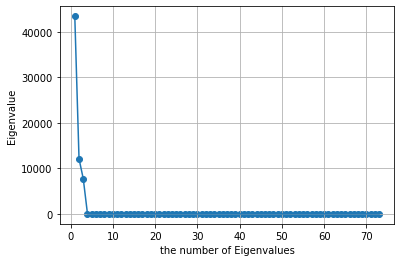

In [27]:
# 同样的数据绘制散点图和折线图
plt.scatter(range(1, data_features.shape[1] + 1), eig_val_2)
plt.plot(range(1, data_features.shape[1] + 1), eig_val_2)
 
# 显示图的标题和xy轴的名字
# 最好使用英文，中文可能乱码
# plt.title("Scree Plot")  
plt.xlabel("the number of Eigenvalues")
plt.ylabel("Eigenvalue")
 
plt.grid()  # 显示网格
plt.show()  # 显示图形

求特征值的贡献度

In [28]:
gx = eig_val_2/np.sum(eig_val_2)
gx

array([ 6.85727550e-01,  1.91292024e-01,  1.22456725e-01,  4.59121303e-04,
        2.08430024e-05,  3.85807104e-06,  2.23212324e-06,  2.16465549e-06,
        1.89968073e-06,  1.48418892e-06,  1.21708741e-06,  1.20205230e-06,
        1.14269737e-06,  1.13410424e-06,  1.10576888e-06,  1.03007767e-06,
        1.01229128e-06,  9.79418794e-07,  9.77596965e-07,  9.36414325e-07,
        9.23462031e-07,  8.98620236e-07,  8.54376705e-07,  8.34898890e-07,
        8.12629808e-07,  8.03133027e-07,  7.90990545e-07,  7.78445782e-07,
        7.52820200e-07,  7.37529959e-07,  7.15669412e-07,  6.95966003e-07,
        6.73987605e-07,  6.56490832e-07,  6.26232649e-07,  5.75280683e-07,
        5.68274194e-07,  5.06348941e-07,  4.98335477e-07,  4.75743312e-07,
        4.42548283e-07,  3.99270563e-07,  3.84164052e-07,  3.62126008e-07,
        3.61148837e-07,  3.54746440e-07,  3.46496600e-07,  3.38502042e-07,
        3.27531808e-07,  3.15871051e-07,  3.14809970e-07,  3.12999773e-07,
        3.06625940e-07,  

求特征值的累计贡献度

In [29]:
lg = np.cumsum(gx)
lg

array([0.68572755, 0.87701957, 0.9994763 , 0.99993542, 0.99995626,
       0.99996012, 0.99996235, 0.99996452, 0.99996642, 0.9999679 ,
       0.99996912, 0.99997032, 0.99997146, 0.9999726 , 0.9999737 ,
       0.99997473, 0.99997575, 0.99997673, 0.9999777 , 0.99997864,
       0.99997956, 0.99998046, 0.99998132, 0.99998215, 0.99998296,
       0.99998377, 0.99998456, 0.99998534, 0.99998609, 0.99998683,
       0.99998754, 0.99998824, 0.99998891, 0.99998957, 0.99999019,
       0.99999077, 0.99999134, 0.99999184, 0.99999234, 0.99999282,
       0.99999326, 0.99999366, 0.99999404, 0.99999441, 0.99999477,
       0.99999512, 0.99999547, 0.99999581, 0.99999614, 0.99999645,
       0.99999677, 0.99999708, 0.99999739, 0.99999769, 0.99999799,
       0.99999827, 0.99999854, 0.9999988 , 0.99999905, 0.99999929,
       0.99999946, 0.99999962, 0.99999974, 0.99999982, 0.99999989,
       0.99999993, 0.99999997, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

In [30]:
#选出主成分
k=[i for i in range(len(lg)) if lg[i]<0.85]
k = list(k)
print(k)

[0]


In [31]:
selectVec = np.matrix(eig_face_2.T[k]).T
selectVe=selectVec*(-1)
selectVec

matrix([[-5.14053303e-03],
        [ 4.21044842e-02],
        [ 2.58717180e-04],
        [-1.51602341e-05],
        [ 3.73364528e-03],
        [-9.99092902e-01],
        [ 1.05417947e-07],
        [-9.44745150e-07],
        [-2.66642437e-06],
        [ 1.73441223e-05],
        [-1.59503960e-05],
        [ 2.11202543e-06],
        [-1.51537604e-05],
        [-1.30845127e-05],
        [ 3.42939653e-06],
        [-2.73944151e-05],
        [-2.25102255e-05],
        [-8.78437492e-06],
        [ 7.13378702e-06],
        [-6.35382366e-06],
        [-7.42800834e-06],
        [ 1.92664555e-05],
        [-1.90284478e-06],
        [ 1.23963807e-05],
        [ 3.64412883e-05],
        [ 3.09224539e-05],
        [ 1.56906829e-07],
        [ 1.52892663e-05],
        [-2.89764446e-05],
        [ 1.67932484e-06],
        [ 2.10010896e-05],
        [-1.61279408e-05],
        [-2.61339043e-04],
        [ 2.61339051e-04],
        [ 2.18364228e-05],
        [ 1.86497644e-06],
        [ 4.72120090e-05],
 

## 特征构建

特征构建是指从原始特征中人工构建新的特征。
特征构建需要很强的洞察力和分析能力，要求我们能够从原始数据中找出一些具有物理意义的特征。
假设原始数据是表格数据，可以使用混合属性或者组合属性来创建新的特征，或是分解或切分原有的特征来创建新的特征。

1. 特征选择

特征选择指根据一定的规则和经验，直接在原有的维度中挑选一部分参与到计算和建模过程，用选择的特征代替所有特征，不改变原有特征，也不产生新的特征值。

特征选择的降维方式好处是可以保留原有维度特征的基础上进行降维，既能满足后续数据处理和建模需求，又能保留维度原本的业务含义，以便于业务理解和应用。对于业务分析性的应用而言，模型的可理解性和可用性很多时候要有限于模型本身的准确率、效率等技术指标。例如，决策树得到的特征规则，可以作为选择用户样本的基础条件，而这些特征规则便是基于输入的维度产生。

2. 维度转换

按照一定数学变换方法，把给定的一组相关变量（维度）通过数学模型将高纬度空间的数据点映射到低纬度空间中，然后利用映射后变量的特征来表示原有变量的总体特征。这种方式是一种产生新维度的过程，转换后的维度并非原来特征，而是之前特征的转化后的表达式，新的特征丢失了原有数据的业务含义。这种降维方法分为线性降维和非线性降维两种：
- 线性降维方法主要有核主成分分析（Kernel PCA），线性判别分析（Latent Dirichlet Allocation，LDA）。
- 非线性降维方法主要有独立成分分析（Independent Component Correlation Algorithm，ICA），主成分分析（Principal components analysis，PCA），因子分析（Factor Analysis，FA），局部线性嵌入（Locally Linear Embedding，LLE）等多种方法。


抽样是一种常用的方法，用于(1)简化用于探索性数据分析的数据，并将算法扩展到大数据应用
(2)量化由于数据分布变化而产生的不确定性。 数据抽样有多种方法，例如不替换抽样(即从数据集中删除每个选定的实例)和替换抽样(即不删除每个选定的实例，从而允许它在样本中被选中多次)。  

References

https://blog.csdn.net/qq_25990967/article/details/121366143